In [1]:
from __future__ import annotations

from IPython.display import HTML
from matplotlib import animation
from PIL import Image
from skimage import draw

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
# comment

In [2]:
def plot_images(img_list: list[Image]) -> animation.Animation:
    def init():
        img.set_data(img_list[0])
        return (img,)

    def animate(i):
        img.set_data(img_list[i])
        return (img,)

    plt.figure(figsize=(15, 15))
    fig = plt.figure()
    ax = fig.gca()
    img = ax.imshow(img_list[0])

    ax.invert_yaxis()  # added

    return animation.FuncAnimation(
        fig,
        animate,
        init_func=init,
        frames=len(img_list),
        interval=20,
        blit=True
    )

In [3]:
class World:
    def __init__(
        self,
        rocket: RectRocket,
        target: Target,
        width: int = 768,
        height: int = 640,
        stop_limit: int = 100
    ) -> None:
        self.rocket = rocket
        self.target = target
        self.width = width
        self.height = height
        self.time = 0
        self.stop_limit = stop_limit
        self.worlds = [np.ones((width, height), dtype=np.uint8)]
        self.distance = []

    def gen_img(self, world):
        buff = np.array((world, world, world)) * 255
        return buff.reshape(self.width, self.height, 3)

    def run(self):
        print('Run the world')

        while True:
            self.time += 1
            xt, yt = self.target.move(self.time)
            xr, yr = self.rocket.move(self.time, self.target)
            self.distance.append(np.linalg.norm(np.array([xt, yt]) - np.array([xr, yr])))
            rt, ct = draw.disk((int(xt), int(yt)), radius=10)  # , shape=self.worlds[-1].shape)
            self.worlds[-1][rt, ct] = 0
            rr, cr = draw.disk((int(xr), int(yr)), radius=10)  # , shape=self.worlds[-1].shape)
            self.worlds[-1][rr, cr] = 0
            self.worlds.append(np.ones((self.width, self.height), dtype=np.uint8))
            if self.time > self.stop_limit:
                print(len(self.worlds))
                print('Stop the world')
                break
            if self.distance[-1] < 10:
                print(len(self.worlds))  # added
                break
        return self.worlds

In [4]:
class Target:
    def __init__(self, r1: int, f1: float, r2: int, f2: float, x0: int, y0: int) -> None:
        self.x0 = x0
        self.y0 = y0
        self.r1 = r1
        self.f1 = f1
        self.r2 = r2
        self.f2 = f2
        self.move(0)

    def move(self, time: int) -> tuple[float, float]:
        self.x = self.x0 + \
                 self.r1 * np.cos(time * 2 * np.pi * self.f1) + \
                 self.r2 * np.cos(time * 2 * np.pi * self.f2)

        self.y = self.y0 + \
                 self.r1 * np.sin(time * 2 * np.pi * self.f1) + \
                 self.r2 * np.sin(time * 2 * np.pi * self.f2)

        return self.x, self.y

In [98]:
class RectRocket:
    def __init__(self, x0: int, y0: int, v: int, angle: float) -> None:
        self.x: float = x0
        self.y = y0
        self.v = v
        self.angle = angle
        self.previous: list = []

    def move(self, time: int, target: Target) -> tuple[float, float]:
        # Put your code here
        # Calculate your angle and apply it to new (x,y) coords
        # Steps:
        # 1. Calculate alpha angle
        # 2. Calcualte new_coordinates
        
        delta_x = target.x - self.x
        delta_y = target.y - self.y
        
        if self.previous:
            prev_target_x = self.previous[-1][0]
            prev_target_y = self.previous[-1][1]

            # estimated_x = target.x + target.x - prev_target_x
            # estimated_y = target.y + target.y - prev_target_y

            # exponential smoothing
            coef = 0.2
            estimated_x = coef * target.x + (1 - coef) * prev_target_x
            estimated_y = coef * target.y + (1 - coef) * prev_target_y

            delta_x = max(min(estimated_x, 639), 0) - self.x
            delta_y = max(min(estimated_y, 767), 0) - self.y

            # delta_x = abs(estimated_x - self.x)
            # delta_y = abs(estimated_y - self.y)

        distance = np.linalg.norm(abs(delta_x - delta_y))

        self.v = min(16.26, self.v * distance * 0.3) 
        # self.v = self.v * distance * 0.05

        # alpha = np.arctan(delta_y / delta_x)
        # alpha = np.arctan(delta_x / delta_y)

        alpha = np.arctan2(delta_y, delta_x)

        self.previous.append((target.x, target.y))

        x_new = self.x + self.v * np.cos(alpha)
        y_new = self.y + self.v * np.sin(alpha)
        self.x = max(min(x_new, 639), 0)
        self.y = max(min(y_new, 767), 0)

        return self.x, self.y

Run the world
36


<Figure size 1500x1500 with 0 Axes>

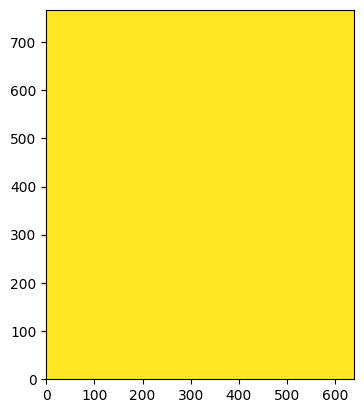

In [99]:
rocket = RectRocket(600, 320, 5, 0)
target = Target(250, 0.01, 5, 0.01, 400, 320)
world = World(rocket, target)


HTML(plot_images(world.run()).to_html5_video())

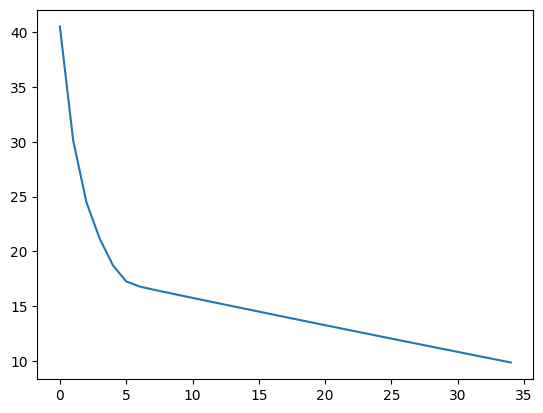

In [100]:
plt.plot(world.distance)